In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as st
import random
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *

np.random.seed(42)

# Point 1 - Basic ABC rejection algorithm

In [3]:
# set problem parameters
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances
N = 500  # max number of accepted samples

In [9]:
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)
seeds = np.arange(10)

acc_rates_basic_ABC = np.zeros((len(seeds),len(eps)))

for i,seed in enumerate(seeds):  
    np.random.seed(seed)
    print(i)
    theta_list = []
    for j,e in enumerate(eps):
        theta, acc_rate = basic_abc(N, M, e, var, var_1, a)
        theta_list.append(theta)
        acc_rates_basic_ABC[i,j] = acc_rate

0
acceptance rate: 0.3022974607013301
acceptance rate: 0.10254306808859721
acceptance rate: 0.043948316779467346
acceptance rate: 0.010460469884307204
1
acceptance rate: 0.3184713375796178
acceptance rate: 0.1016880211511084
acceptance rate: 0.044642857142857144
acceptance rate: 0.010495602342618442
2
acceptance rate: 0.31887755102040816
acceptance rate: 0.10245901639344263
acceptance rate: 0.04095339503644852
acceptance rate: 0.009799694249539415
3
acceptance rate: 0.31605562579013907
acceptance rate: 0.10068465565847765
acceptance rate: 0.0406371911573472
acceptance rate: 0.010442555502182494
4
acceptance rate: 0.30413625304136255
acceptance rate: 0.11076650420912716
acceptance rate: 0.043848110146452686
acceptance rate: 0.011185432093241762
5
acceptance rate: 0.32530904359141183
acceptance rate: 0.1025220422390814
acceptance rate: 0.04611269943742507
acceptance rate: 0.010830012129613585
6
acceptance rate: 0.3255208333333333
acceptance rate: 0.10820168794633196
acceptance rate: 0.04

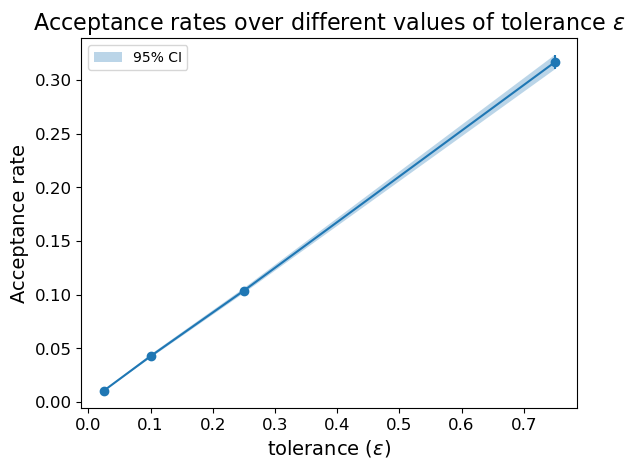

In [43]:
data = acc_rates_basic_ABC.copy()

confidence_level = 0.95

means = np.mean(data, axis=0)
std_devs = np.std(data, axis=0, ddof=1)  # ddof=1 for sample standard deviation
standard_errors = std_devs / np.sqrt(data.shape[0])

# CI
margin_of_error = st.t.ppf((1 + confidence_level) / 2, data.shape[0] - 1) * standard_errors
confidence_intervals = np.column_stack([means - margin_of_error, means + margin_of_error])

plt.errorbar(eps, means, yerr=margin_of_error, fmt='-o')
plt.fill_between(eps, confidence_intervals[:, 0], confidence_intervals[:, 1], alpha=0.3, label='95% CI')

plt.xlabel(r'tolerance ($\epsilon$)', fontsize=14)
plt.ylabel('Acceptance rate', fontsize=14)
plt.title(r'Acceptance rates over different values of tolerance $\epsilon$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')
plt.legend()

plt.show()

In [25]:
print(means) 
print(margin_of_error)

[0.31676948 0.10381305 0.04275788 0.01064006]
[0.00673938 0.00228266 0.00153539 0.00027899]


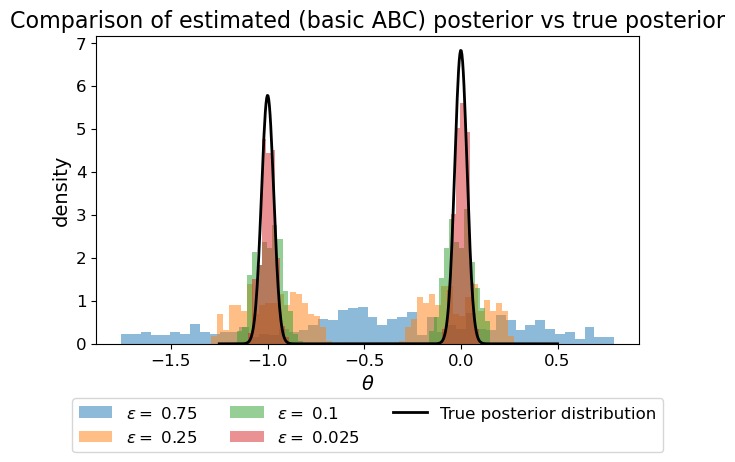

In [25]:
plt.figure(figsize=(7,4))

for i in (range(len(eps))):
    plt.hist(theta_list[i], density=True, bins=50, alpha=0.5, label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True posterior distribution', color='black', linewidth=2)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.title('Comparison of estimated (basic ABC) posterior vs true posterior', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize='large')  
plt.show()

In [26]:
sample_mean = 0

print("mu1 is:", var/(var+var_1/M)*sample_mean, ", sdt1 is:", np.sqrt(var_1/(M+var_1/var)))
print("mu2 is:", var/(var+var_1/M)*(sample_mean-a), ", std2 is:", np.sqrt(var_1/(M+var_1/var)))
print("alpha is:",alpha)

print("mean of true mixture distribution is:",(1-alpha)*var/(var+var_1/M)*(sample_mean-a))

mu1 is: 0.0 , sdt1 is: 0.03161750745616664
mu2 is: -0.9996667777407531 , std2 is: 0.03161750745616664
alpha is: 0.5415566948980146
mean of true mixture distribution is: -0.4582905415881227


# Point 3 - ABC-MCMC algorithm

## ver. 1.1 - effective sample size

In [48]:
### Update effective sample size: ESS = N c(0)/sigma^2
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances

N_eff = 500  # effective size
nu_squared = 1  # TEMP

# estimate the asymptotic variance (covariance method)
N_max = 5000  # 10*N_eff
e = 0.1

c_hat = []
theta, acc_rate = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)

acceptance rate: 0.0626


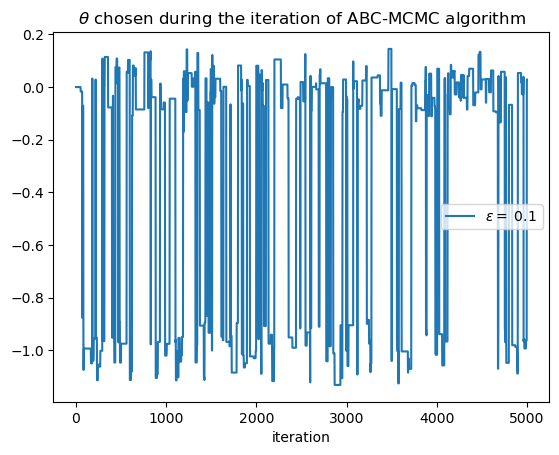

In [28]:
plt.figure()
plt.plot(theta, label = r'$\epsilon =$ %s' % e)
plt.legend()
plt.xlabel('iteration')
plt.title(r'$\theta$ chosen during the iteration of ABC-MCMC algorithm')

plt.show()

We estimate now the number of iterations to have $N_{eff} \approx 500$.

In [29]:
### update (cont.)
b = 1000  # burn-in
mu_hat = theta[b:].mean()

k = 0
while k < N_max-1:
    c_hat.append(1/(N_max-k-1)*np.multiply(theta[b:N_max-k+1] - mu_hat, theta[b+k:] - mu_hat).sum())
    k = k + 1

In [30]:
### update (cont.)
for k, _ in enumerate(c_hat):
    if c_hat[2*k] - c_hat[2*k+1] < 0:
        M_eff = 2*k
        break
print(M_eff)

72


In [31]:
var_M_hat = c_hat[0] + 2*sum(c_hat[1:M_eff+1])
var_hat = c_hat[0] + 2*sum(c_hat[1:])

print('sigma^2^hat =', var_hat)
print('sigma^2^hat_M =', var_M_hat)

sigma^2^hat = -11.519517656137939
sigma^2^hat_M = 8.102161901276641


In [32]:
N_max = math.ceil(N_eff*var_M_hat/c_hat[0])
print('N_max =', N_max)

N_max = 21785


Now let us plot as in basic MCMC the estimated posterior for different values of $\epsilon$.

In [34]:
### update (cont.)
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)
seeds = np.arange(10)

acc_rates_ABC_MCMC = np.zeros((len(seeds),len(eps)))

for i,seed in enumerate(seeds):  
    np.random.seed(seed)
    print(i)
    theta_list = []
    for j,e in enumerate(eps):
        theta, acc_rate = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)
        theta_list.append(theta)
        acc_rates_ABC_MCMC[i,j] = acc_rate

0
acceptance rate: 0.3831994491622676
acceptance rate: 0.13954555887078265
acceptance rate: 0.05347716318567822
acceptance rate: 0.015285747073674546
1
acceptance rate: 0.38760615102134494
acceptance rate: 0.13853568969474409
acceptance rate: 0.05586412669267845
acceptance rate: 0.01606610052788616
2
acceptance rate: 0.38476015607069086
acceptance rate: 0.14372274500803306
acceptance rate: 0.05958228138627496
acceptance rate: 0.013816846453982097
3
acceptance rate: 0.38173054854257515
acceptance rate: 0.14321781042001377
acceptance rate: 0.05453293550608217
acceptance rate: 0.01418407160890521
4
acceptance rate: 0.3922882717466146
acceptance rate: 0.14496212990589855
acceptance rate: 0.05664448014689006
acceptance rate: 0.013954555887078265
5
acceptance rate: 0.38430112462703697
acceptance rate: 0.13619462933210924
acceptance rate: 0.057149414734909344
acceptance rate: 0.013357815010328207
6
acceptance rate: 0.3832912554509984
acceptance rate: 0.14083084691301354
acceptance rate: 0.055

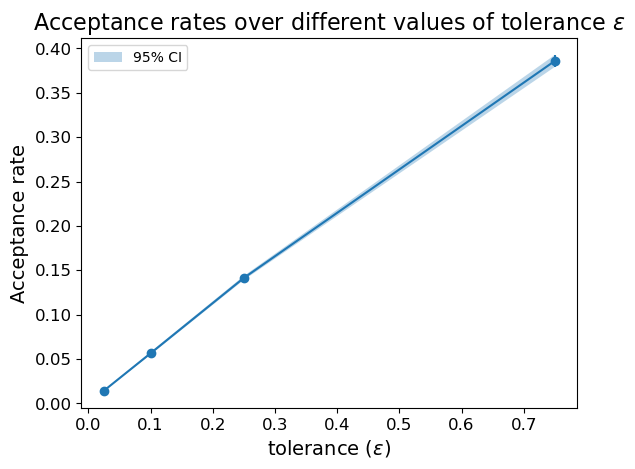

In [42]:
data = acc_rates_ABC_MCMC.copy()

confidence_level = 0.95

means_2 = np.mean(data, axis=0)
std_devs_2 = np.std(data, axis=0, ddof=1)  # ddof=1 for sample standard deviation
standard_errors_2 = std_devs / np.sqrt(data.shape[0])

# CI
margin_of_error_2 = st.t.ppf((1 + confidence_level) / 2, data.shape[0] - 1) * standard_errors_2
confidence_intervals_2 = np.column_stack([means_2 - margin_of_error_2, means_2 + margin_of_error_2])

plt.errorbar(eps, means_2, yerr=margin_of_error_2, fmt='-o')
plt.fill_between(eps, confidence_intervals_2[:, 0], confidence_intervals_2[:, 1], alpha=0.3, label='95% CI')

plt.xlabel(r'tolerance ($\epsilon$)', fontsize=14)
plt.ylabel('Acceptance rate', fontsize=14)
plt.title(r'Acceptance rates over different values of tolerance $\epsilon$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')
plt.legend()

plt.show()

In [44]:
print(means_2) 
print(margin_of_error_2)

[0.38583888 0.14139087 0.05651136 0.01439523]
[0.00673938 0.00228266 0.00153539 0.00027899]


Let us now compare the posterior distributions obtained.

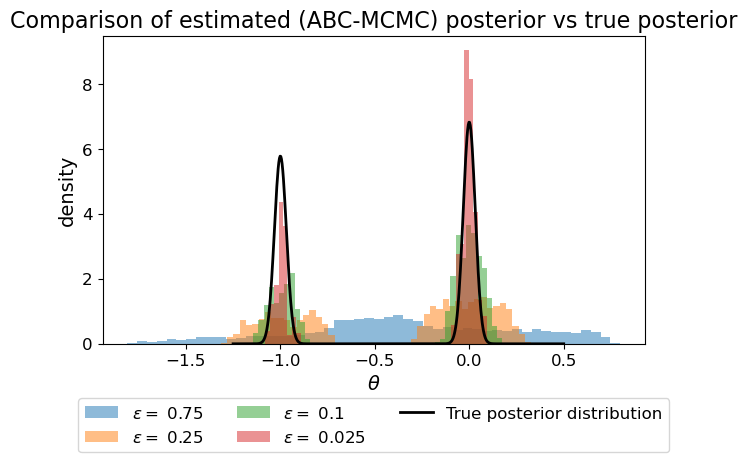

In [45]:
plt.figure(figsize=(7,4))

for i in (range(len(eps))):
    plt.hist(theta_list[i], density=True, bins=50, alpha=0.5, label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True posterior distribution', color='black', linewidth=2)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.title('Comparison of estimated (ABC-MCMC) posterior vs true posterior', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize='large')  
plt.show()

We can look also at the evolution of the samples $\theta_i$ chosen by ABC-MCMC algorithm

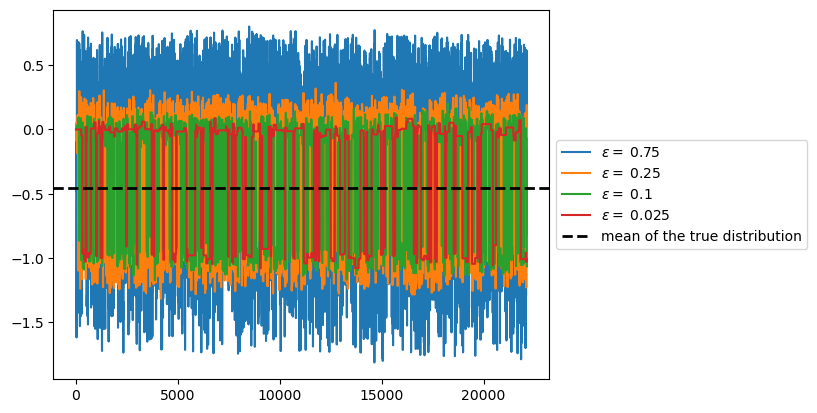

In [49]:
plt.figure()

for i in (range(len(eps))):
    plt.plot(theta_list[i], label=r'$\epsilon =$ %s' % eps[i])
    
plt.axhline(y=(1-alpha)*(sample_mean-a), color='black', linestyle='--', linewidth=2, label='mean of the true distribution')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

**Comparison acceptance rates**

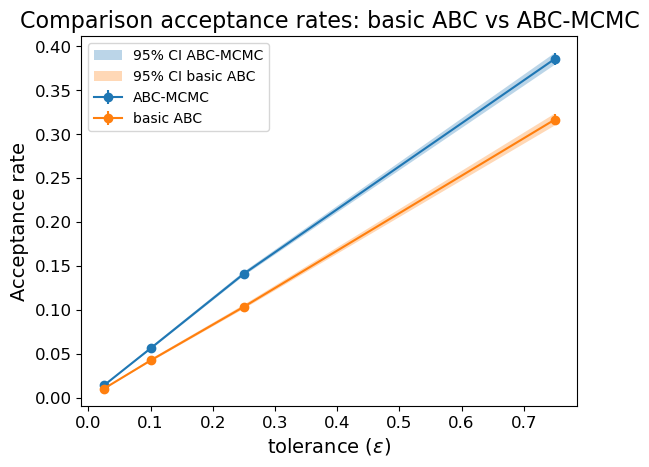

In [41]:
plt.errorbar(eps, means_2, yerr=margin_of_error_2, fmt='-o', label='ABC-MCMC')
plt.fill_between(eps, confidence_intervals_2[:, 0], confidence_intervals_2[:, 1], alpha=0.3, label='95% CI ABC-MCMC')

plt.errorbar(eps, means, yerr=margin_of_error, fmt='-o', label='basic ABC')
plt.fill_between(eps, confidence_intervals[:, 0], confidence_intervals[:, 1], alpha=0.3, label='95% CI basic ABC')

plt.xlabel(r'tolerance ($\epsilon$)', fontsize=14)
plt.ylabel('Acceptance rate', fontsize=14)
plt.title('Comparison acceptance rates: basic ABC vs ABC-MCMC', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')
plt.legend()

plt.show()

# Point 4 - Calculate summary statistic

In [4]:
# Define parameters of pharmacokinetic model
K_e = 0.08
K_a = 1.5
Cl = 0.04
sigma = 0.2
D = 4

np.random.seed(42)

Let us use the Euler-Maruyama method to estimate $X(t)$.

In [6]:
t, X_t = simulate_Xt_full(K_e, K_a, Cl, sigma)

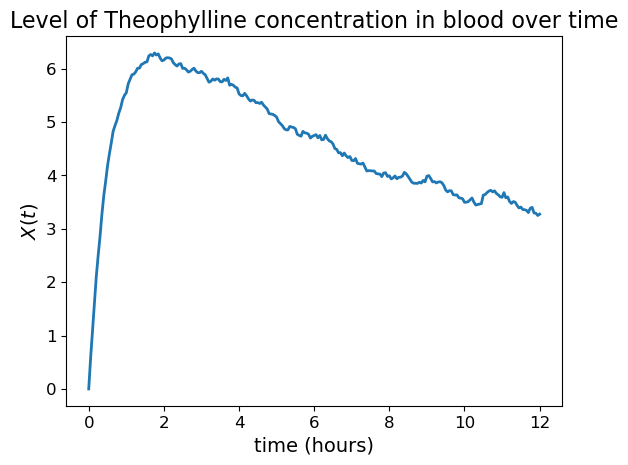

In [7]:
plt.figure()

plt.plot(t, X_t, label=r'$X(t)$', linewidth=2)
plt.xlabel('time (hours)', fontsize=14)
plt.ylabel(r'$X(t)$', fontsize=14)
plt.title('Level of Theophylline concentration in blood over time', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')

plt.show()

We fit now a Linear Regression.

In [8]:
xs = simulate_Xt_times(K_e, K_a, Cl, sigma)
print('data are:', xs)

data are: [2.35575519 3.98260536 5.82117124 6.35507429 6.13747664 5.69180909
 5.07323034 4.28439413 3.35932484]


In [9]:
n_data = 10000
X = np.zeros((n_data, 9)) 
Y = np.zeros((n_data, 4)) #4 is the number of parameters of interest

for j in range(n_data):
    K_a = np.exp(np.random.normal(0.14, 0.4))
    K_e = np.exp(np.random.normal(-2.7, 0.6))
    Cl = np.exp(np.random.normal(-3, 0.8))
    sigma = np.exp(np.random.normal(-1.1, 0.3))
    
    theta = [K_e, K_a, Cl, sigma]
    Y[j,:] = theta

    X[j,:] = simulate_Xt_times(K_e, K_a, Cl, sigma)

In [10]:
# Fit linear regression model
model = LinearRegression()
model.fit(X, Y)

# Get the estimated coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Estimated Coefficients:", coefficients)
print("Intercept:", intercept)

Estimated Coefficients: [[-4.65332884e-03 -1.26346701e-03  1.59033899e-03  5.10548161e-03
   2.80861112e-03  9.64558357e-04  1.55194465e-06 -5.65704900e-03
  -8.03615918e-03]
 [-7.26770906e-02  1.21219248e-01  1.16775832e-01 -1.11404838e-01
  -7.97863645e-02  2.51813581e-02 -8.25134089e-03  2.94342908e-02
   2.17882174e-02]
 [ 8.33254714e-03 -8.60735410e-03  1.49268395e-03  9.99378981e-04
   8.26866536e-04 -1.36562546e-03 -1.30356509e-03 -1.20242109e-03
  -6.27991772e-03]
 [ 5.56503631e-03 -2.48945016e-03 -4.80703988e-03  7.83265103e-03
  -9.58055898e-03  8.23045995e-03 -2.37709738e-03  1.00986724e-03
  -1.97126863e-03]]
Intercept: [0.07732359 1.25386143 0.09919241 0.34527685]


Finally, we can calculate the summary statistic $S(\mathcal{D})$ using the first data we generated. 

$S(\mathcal{D}) = \mathbb{E}[\theta| \mathcal{D}]= \begin{bmatrix} \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \end{bmatrix} = \begin{bmatrix} \beta_0^{(1)} \\ \beta_0^{(2)} \\ \beta_0^{(3)} \\ \beta_0^{(4)} \end{bmatrix} + \begin{bmatrix} \beta_1^{(1)} \ ... \ \beta_9^{(1)} \\ \beta_1^{(2)} \ ... \ \beta_9^{(2)} \\ \beta_1^{(3)} \ ... \ \beta_9^{(3)} \\ \beta_1^{(4)} \ ... \ \beta_9^{(4)} \end{bmatrix} \cdot \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_9 \end{bmatrix}$

In [11]:
S_D = intercept + coefficients@xs
print("Summary statistic is", S_D)
print("They are generated from data with parameters", [0.08,1.5,0.04,0.2])

Summary statistic is [0.07453559 1.3482879  0.06402323 0.34395742]
They are generated from data with parameters [0.08, 1.5, 0.04, 0.2]


# Point 5 - ABC_MCMC on Pmodel and estimate of the posterior mean $\theta^{PM}$

In [15]:
seeds = np.arange(10)
N_max = 10000
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [1., 0.7, 0.25]

acc_rates_list = np.zeros((len(seeds),len(eps)))

for i,seed in enumerate(seeds):  
    np.random.seed(seed)
    print(i)
    theta_list = []
    for j,e in enumerate(eps):
        theta, acc_rate = abc_mcmc_pharma(N_max, M, e, S_D, intercept, coefficients)
        list_theta.append(theta)
        acc_rates_list[i,j] = acc_rate

0
acceptance rate: 0.3476
acceptance rate: 0.3353
acceptance rate: 0.2255
1
acceptance rate: 0.3479
acceptance rate: 0.3303
acceptance rate: 0.2111
2
acceptance rate: 0.3504
acceptance rate: 0.342
acceptance rate: 0.2279
3
acceptance rate: 0.3469
acceptance rate: 0.3368
acceptance rate: 0.2276
4
acceptance rate: 0.3497
acceptance rate: 0.3373
acceptance rate: 0.2203
5
acceptance rate: 0.3446
acceptance rate: 0.3341
acceptance rate: 0.2194
6
acceptance rate: 0.3463
acceptance rate: 0.3457
acceptance rate: 0.2325
7
acceptance rate: 0.3458
acceptance rate: 0.3284
acceptance rate: 0.2291
8
acceptance rate: 0.3562
acceptance rate: 0.3355
acceptance rate: 0.2298
9
acceptance rate: 0.3433
acceptance rate: 0.3341
acceptance rate: 0.2171


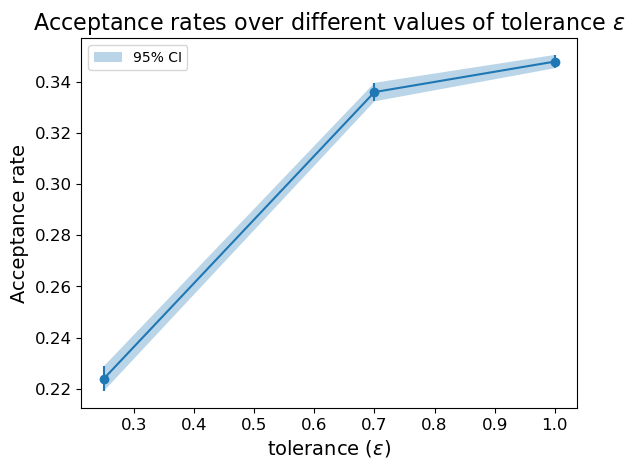

In [18]:
data = acc_rates_list.copy()

confidence_level = 0.95

means = np.mean(data, axis=0)
std_devs = np.std(data, axis=0, ddof=1)  # ddof=1 for sample standard deviation
standard_errors = std_devs / np.sqrt(data.shape[0])

# CI
margin_of_error = st.t.ppf((1 + confidence_level) / 2, data.shape[0] - 1) * standard_errors
confidence_intervals = np.column_stack([means - margin_of_error, means + margin_of_error])

plt.errorbar(eps, means, yerr=margin_of_error, fmt='-o')
plt.fill_between(eps, confidence_intervals[:, 0], confidence_intervals[:, 1], alpha=0.3, label='95% CI')

plt.xlabel(r'tolerance ($\epsilon$)', fontsize=14)
plt.ylabel('Acceptance rate', fontsize=14)
plt.title(r'Acceptance rates over different values of tolerance $\epsilon$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')
plt.legend()

plt.show()

In [73]:
print(means)
print(margin_of_error)

[0.34787 0.33595 0.22403]
[0.00259553 0.00362106 0.00483524]


In [28]:
np.random.seed(42)

N_max = 10000
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [1., 0.7, 0.25]
list_theta = []

for e in eps:
    theta, acc_rate = abc_mcmc_pharma(N_max, M, e, S_D, intercept, coefficients)
    list_theta.append(theta)

acceptance rate: 0.3458
acceptance rate: 0.3312
acceptance rate: 0.2201


In [40]:
list_theta_PM = []

for elem in list_theta:
    list_theta_PM.append(np.mean(elem[3000:,:], axis=0))

In [41]:
print(list_theta_PM)

[array([0.07456369, 1.2347917 , 0.0707713 , 0.3556165 ]), array([0.07595098, 1.23836578, 0.07681563, 0.3536352 ]), array([0.0689889 , 1.25249065, 0.06346742, 0.34117893])]


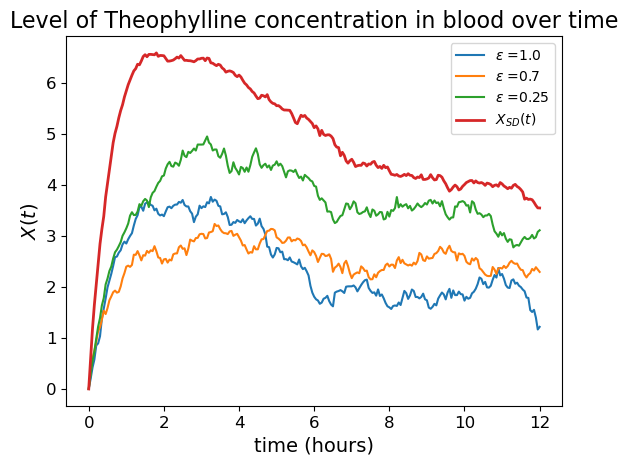

In [46]:
np.random.seed(40)
theta_SD = [0.08, 1.5, 0.04, 0.2]

for i, theta_PM in enumerate(list_theta_PM):
    t, X_t = simulate_Xt_full(theta_PM[0], theta_PM[1], theta_PM[2], theta_PM[3])
    plt.plot(t, X_t, label=r'$\epsilon$ =%s' % eps[i])
t_real, X_t_real = simulate_Xt_full(theta_SD[0], theta_SD[1], theta_SD[2], theta_SD[3])    
plt.plot(t_real, X_t_real, label=r'$X_{SD}(t)$', linewidth=2)
plt.xlabel('time (hours)', fontsize=14)
plt.ylabel(r'$X(t)$', fontsize=14)
plt.title('Level of Theophylline concentration in blood over time', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')
plt.legend()

plt.show()

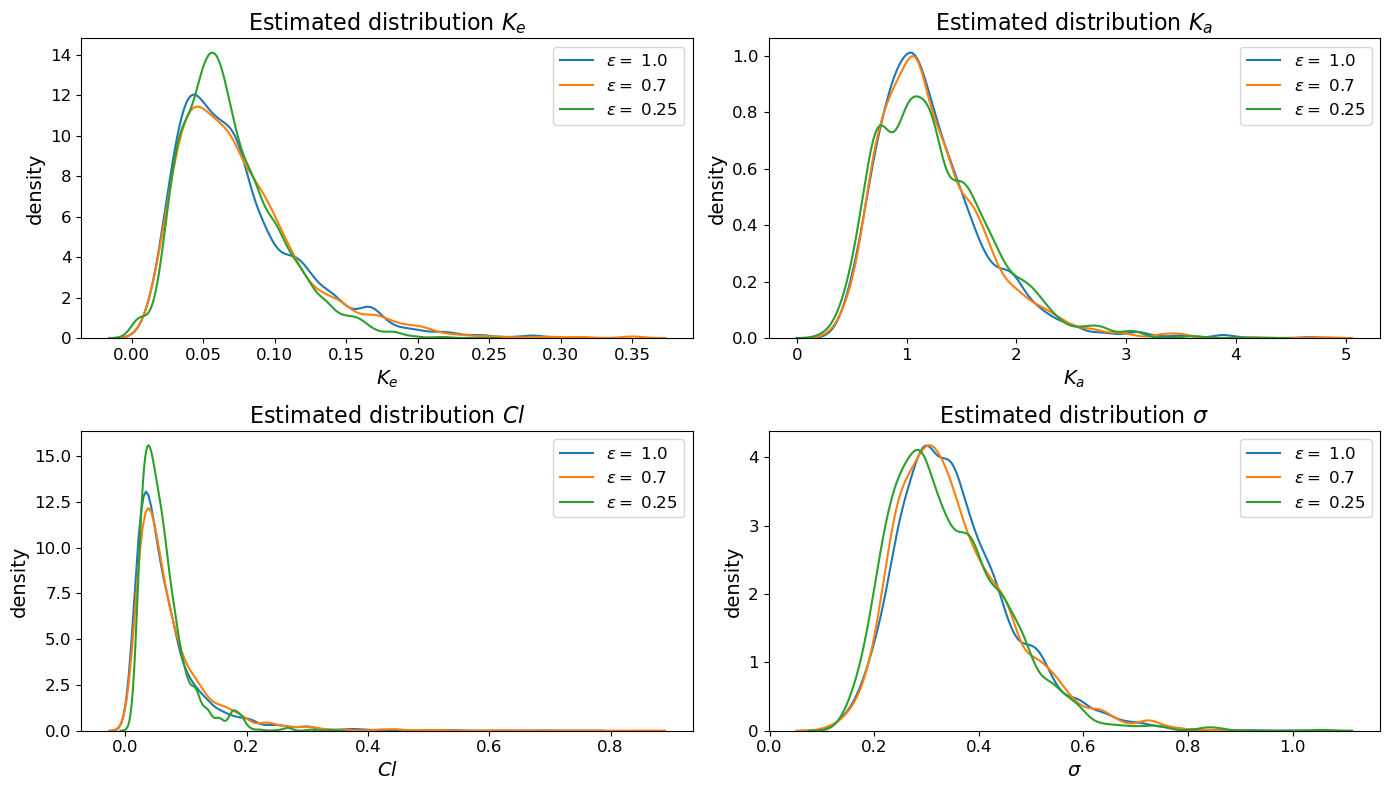

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
titles = [r'Estimated distribution $K_e$',r'Estimated distribution $K_a$', r'Estimated distribution $Cl$', r'Estimated distribution $\sigma$']
xlabels = [r'$K_e$', r'$K_a$', r'$Cl$', r'$\sigma$']

for j, ax in enumerate(axes.flatten()):
    for i in range(len(eps)):
        sns.kdeplot(list_theta[i][3000:, j], label=r'$\epsilon =$ %s' % eps[i], ax=ax)

    ax.set_xlabel(xlabels[j], fontsize=14)
    ax.set_ylabel('density', fontsize=14)
    ax.set_title(titles[j], fontsize=16)
    ax.tick_params(axis='both', which='both', labelsize='large')
    ax.legend(loc='upper right', fontsize='large')

plt.tight_layout()
plt.savefig('marginal_distr.png')
plt.show()

# Point 6: Estimation of $\mathbb{E}[X_9]$.

### Crude Monte Carlo

In [48]:
np.random.seed(30)

In [50]:
list_theta_PM

[array([0.07456369, 1.2347917 , 0.0707713 , 0.3556165 ]),
 array([0.07595098, 1.23836578, 0.07681563, 0.3536352 ]),
 array([0.0689889 , 1.25249065, 0.06346742, 0.34117893])]

In [51]:
theta_0 = [0.07, 1.15, 0.05, 0.33]

experiments = 1000
estimations_mean = []
data = []

for theta_PM in list_theta_PM:
    curr_sum = 0
    x_9s = []
    K_e = theta_PM[0]
    K_a = theta_PM[1]
    Cl = theta_PM[2]
    sigma = theta_PM[3]
    
    for i in range(experiments):
        
        x_9 = simulate_Xt_times(K_e, K_a, Cl, sigma)[-1]
        x_9s.append(x_9)
        curr_sum += x_9
    
    data.append(x_9s)
    estimations_mean.append(curr_sum/experiments)

In [52]:
estimations_mean

[1.7349997261391896, 1.6408819573812987, 1.9325438018925274]

In [53]:
estimations_variance = []

for i in range(3):
    estimations_variance.append(np.var(data[i]))

In [54]:
estimations_variance

[0.6661715150317475, 0.6877816981190629, 0.6830488719192978]

In [55]:
CIs = []
for i in range(3):
    CIs.append([estimations_mean[i]-st.norm.ppf(0.975)*np.sqrt(estimations_variance[i]/experiments), 
               estimations_mean[i]+st.norm.ppf(0.975)*np.sqrt(estimations_variance[i]/experiments)])

In [56]:
for i in range(3):
    print(r"95% CI for X_9 with epsilon=", eps[i], "is:", CIs[i])

95% CI for X_9 with epsilon= 1.0 is: [1.6844124704070007, 1.7855869818713785]
95% CI for X_9 with epsilon= 0.7 is: [1.5894807407522007, 1.6922831740103967]
95% CI for X_9 with epsilon= 0.25 is: [1.8813197439314524, 1.9837678598536024]


### Antithetic variables

In [59]:
theta_0 = [0.07, 1.15, 0.05, 0.33]
experiments = 1000
experiments = experiments//2
estimations_mean_AV = []
data_AV = []
np.random.seed(39)

for j,theta_PM in enumerate(list_theta_PM):
    
    curr_sum = 0
    x_9s = []
    x_9s_AV = []
    
    K_e = theta_PM[0]
    K_a = theta_PM[1]
    Cl = theta_PM[2]
    sigma = theta_PM[3]
    
    for i in range(experiments):
        x_9 = simulate_Xt_times(K_e, K_a, Cl, sigma)[-1]
        x_9s.append(x_9)
    
    for i in range(experiments):
        x_9_AV = simulate_Xt_times_AV(K_e, K_a, Cl, sigma)[-1]
        curr_sum += (x_9_AV +x_9s[i])/2
        x_9s_AV.append((x_9_AV +x_9s[i])/2)
        
    data_AV.append(x_9s_AV)

    estimations_mean_AV.append(curr_sum/(experiments))

In [60]:
print(estimations_mean_AV)
print(estimations_mean)

[1.797849752607691, 1.6315236443845538, 1.9506128288777824]
[1.7349997261391896, 1.6408819573812987, 1.9325438018925274]


In [61]:
estimations_variance_AV = []

for i in range(3):
    estimations_variance_AV.append(np.var(data_AV[i]))

In [72]:
print(estimations_variance_AV)
print(estimations_variance)

[0.34354612932578643, 0.34183864105389034, 0.3474856348438717]
[0.6661715150317475, 0.6877816981190629, 0.6830488719192978]


In [63]:
CIs_AV = []
for i in range(3):
    CIs_AV.append([estimations_mean_AV[i]-st.norm.ppf(0.975)*np.sqrt(estimations_variance_AV[i]/(experiments)), 
               estimations_mean_AV[i]+st.norm.ppf(0.975)*np.sqrt(estimations_variance_AV[i]/(experiments))])

In [64]:
for i in range(3):
    print(r"95% CI for X_9 with crude MC and with epsilon=", eps[i], "is:", CIs[i])
    print(r"95% CI for X_9 with AV and with epsilon=", eps[i], "is:", CIs_AV[i])
    print("\n")

95% CI for X_9 with crude MC and with epsilon= 1.0 is: [1.6844124704070007, 1.7855869818713785]
95% CI for X_9 with AV and with epsilon= 1.0 is: [1.7464743049928262, 1.849225200222556]


95% CI for X_9 with crude MC and with epsilon= 0.7 is: [1.5894807407522007, 1.6922831740103967]
95% CI for X_9 with AV and with epsilon= 0.7 is: [1.5802760285779514, 1.6827712601911562]


95% CI for X_9 with crude MC and with epsilon= 0.25 is: [1.8813197439314524, 1.9837678598536024]
95% CI for X_9 with AV and with epsilon= 0.25 is: [1.898943655146524, 2.002282002609041]




In [65]:
for i in range(3):
    print(r"95% standard error for X_9 with crude MC and with epsilon=", eps[i], "is:",np.sqrt(estimations_variance[i]/(experiments*2)))
    print(r"95% standard error for X_9 with AV and with epsilon=", eps[i], "is:", np.sqrt(estimations_variance_AV[i]/(experiments)))
    print("\n")

95% standard error for X_9 with crude MC and with epsilon= 1.0 is: 0.025810298623451598
95% standard error for X_9 with AV and with epsilon= 1.0 is: 0.02621244472863172


95% standard error for X_9 with crude MC and with epsilon= 0.7 is: 0.026225592426465084
95% standard error for X_9 with AV and with epsilon= 0.7 is: 0.026147223219833128


95% standard error for X_9 with crude MC and with epsilon= 0.25 is: 0.026135203690028853
95% standard error for X_9 with AV and with epsilon= 0.25 is: 0.02636230774586594




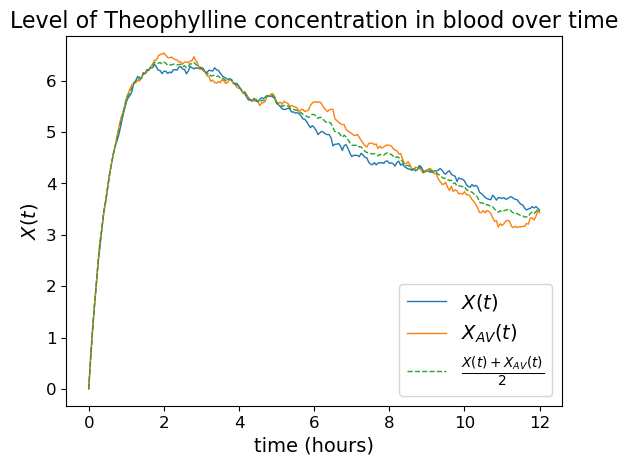

In [71]:
np.random.seed(40)
theta_SD = [0.08, 1.5, 0.04, 0.2]

t_anti, X_t_anti = simulate_Xt_times_AV_full(theta_SD[0], theta_SD[1], theta_SD[2], theta_SD[3]) 
t_real, X_t_real = simulate_Xt_full(theta_SD[0], theta_SD[1], theta_SD[2], theta_SD[3])    

plt.plot(t_real, X_t_real, label=r'$X(t)$', linewidth=1)
plt.plot(t_anti, X_t_anti, label=r'$X_{AV}(t)$', linewidth=1)
plt.plot(t_real, (X_t_real+X_t_anti)/2, '--', linewidth = 1, label=r'$\frac{X(t)+X_{AV}(t)}{2}$')

plt.xlabel('time (hours)', fontsize=14)
plt.ylabel(r'$X(t)$', fontsize=14)
plt.title('Level of Theophylline concentration in blood over time', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')
plt.legend(fontsize=14)

plt.show()